In [5]:
%config IPCompleter.greedy=True
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import varilog as vrl

In [11]:
vrl.MD.names

['mte2015_optim', 'leir2015_test']

In [19]:
mdleir = vrl.MD('leir2015_test', '1.0')
mdleir.cycles['2015-12-14T00:33:41.255000'].EAX_EBTFMH.Delay.delay

MD found with 1 cycles and 46 devices.


1980.0

In [12]:
md = vrl.MD(vrl.MD.names.mte2015_optim, '2.0')

MD found with 1002 cycles and 63 devices.


In [35]:
md.users

['chernals', 'sterbini']

In [77]:
def efficiency_analysis(cycle):
    extr_eff = 100 * (
        cycle.F16_BCT126.Acquisition.totalIntensityPreferred.value/cycle.PR_BCT.HotspotIntensity.dcBefEje1.value)
    mte_eff = trap(cycle.F16_BCT126.Sampler.sampleData.value, 59, 204, 3)
    intensity = cycle.PR_BCT.HotspotIntensity.dcBefEje1.value
    if extr_eff > 97 and mte_eff > 17:
        return [intensity, extr_eff, mte_eff]
d1600g = np.array(list(filter(None, [efficiency_analysis(x) for x in md.cycles.values()])))
print(np.mean(d1600g[:,1]))
print(np.median(d1600g[:,1]))
print(np.std(d1600g[:,1]))
print(np.mean(d1600g[:,2]))
print(np.median(d1600g[:,2]))
print(np.std(d1600g[:,2]))

In [45]:
md.cycles['2015-11-08T23:00:15.099999']

In [41]:
md.parameters.F16_BCT203.Sampler.sampleData

[[datetime.datetime(2015, 11, 8, 22, 59, 59, 500000)
  array([ 3752.51757812,  3752.53881836,  3752.54614258, ...,  3752.73120117,
        3752.75634766,  3752.75634766])]
 [datetime.datetime(2015, 11, 8, 23, 0, 15, 99999)
  array([ 3758.68994141,  3758.63647461,  3758.69360352, ...,  3758.89331055,
        3758.86474609,  3758.88964844])]
 [datetime.datetime(2015, 11, 8, 23, 0, 58, 299999)
  array([ 3758.32788086,  3758.34204102,  3758.32080078, ...,  3758.50268555,
        3758.54541016,  3758.50268555])]
 ..., 
 [datetime.datetime(2015, 11, 9, 6, 1, 58, 299999)
  array([ 3779.00415039,  3779.0078125 ,  3779.02563477, ...,  3779.23388672,
        3779.2121582 ,  3779.25170898])]
 [datetime.datetime(2015, 11, 9, 6, 2, 16, 299999)
  array([ 3762.34960938,  3762.36401367,  3762.34960938, ...,  3762.50317383,
        3762.57470703,  3762.50683594])]
 [datetime.datetime(2015, 11, 9, 6, 2, 34, 299999)
  array([ 3763.01098633,  3762.97509766,  3762.96435547, ...,  3763.18237305,
        376

CPU times: user 98.6 ms, sys: 10 ms, total: 109 ms
Wall time: 101 ms


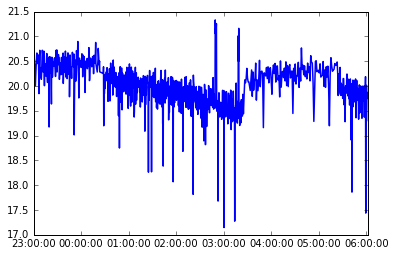

In [114]:
%%time
#md = vrl.MD('mte2015_optim', '2.0')
spills = md.parameters.F16_BCT126.Sampler.sampleData
trapping = np.array(list(map(lambda x: [x[0], trap(x[1], 59, 204, 3)], spills)))
plt.plot(trapping[:,0], trapping[:,1])

Averaging over 1002 cycles
CPU times: user 37.7 ms, sys: 2.63 ms, total: 40.4 ms
Wall time: 38.5 ms


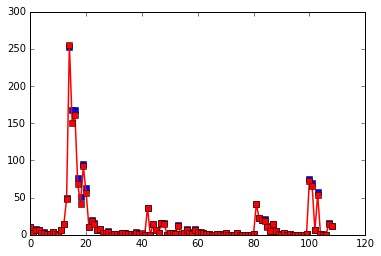

In [26]:
%%time
blms = md.parameters.CPS_BLM.Acquisition.lastLosses
print("Averaging over %d cycles" % len(blms))
plt.plot(np.mean([x[1] for x in blms], axis=0), 'bs', markersize=6)
plt.plot(np.median([x[1] for x in blms], axis=0), 'rs-', markersize=6)

In [68]:
def trap(dd, l, r, s):
    # 126 59 204 3
    # 212 57 197 1
    # 372 79 219 1
    left = l
    right = r
    offset = s
    indices = np.arange(left, right+1)
    compensation = -(dd[indices[0]]-dd[indices[-1]])/(indices.size-1)
    baseline = np.mean(dd[left-10:left])
    spill = dd[indices]-(indices-indices[0])*compensation-baseline
    if np.trapz(spill) > -1000:
        return -1
    isl_l = int((spill.size-1)/5)
    isl = np.trapz(spill[0:4*isl_l-s])
    core = np.trapz(spill[4*isl_l-s-1:])
    total = np.trapz(spill)
    eff = (isl/total)*100/4
    return eff